In [1]:
import pandas as pd
import numpy as np
from fontTools.feaLib import location
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import cv2
from datetime import datetime, timedelta
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score, KFold

pd.set_option('display.max_columns', None)

fire_data = pd.read_csv('NFDB_point_20240613.txt', sep=",", header=0)
fire_data.head()



,FID,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,OUT_DATE,SIZE_HA,CAUSE,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,CFS_NOTE1,CFS_NOTE2,ACQ_DATE
0,0,BC-2023-2023-C23369,BC,,2023-C23369,C23369,51.8197,-122.0729,2023,9,27,2023-09-27 00:00:00,NaN,2023-09-28 00:00:00,0.010,H,H,Fire,FUL,,,NE of Alkali Creek,,,2024-05-06 00:00:00
1,1,BC-2023-2023-R50580,BC,,2023-R50580,KITSELAS ROAD,54.5692,-128.4611,2023,6,2,2023-06-02 00:00:00,NaN,2023-06-10 00:00:00,1.400,H,H,Fire,FUL,,,N of 12km on Kitselas Rd,,,2024-05-06 00:00:00
2,2,BC-2023-2023-K40937,BC,,2023-K40937,,50.1166,-119.2738,2023,6,27,2023-06-27 00:00:00,NaN,2023-06-27 00:00:00,0.009,H,H,Fire,FUL,,,Oyama Lake,,,2024-05-06 00:00:00
3,3,BC-2023-2023-R10108,BC,,2023-R10108,LAUREL ROAD,54.2270,-125.6543,2023,4,28,2023-04-28 00:00:00,NaN,2023-05-01 00:00:00,1.100,H,H,Fire,FUL,,,Laurel Rd,,,2024-05-06 00:00:00
4,4,BC-2023-2023-K50058,BC,,2023-K50058,Campbell Mountain,49.5187,-119.5348,2023,4,17,2023-04-17 00:00:00,NaN,2023-04-18 00:00:00,0.009,H,H,Fire,FUL,,,Campbell Mountain,,,2024-05-06 00:00:00


# Section 1: Function Definitions

> In this section we define several functions required for the process of assigning regions and temperature data for each instance. 

## Function 1: Round to Nearest 2
> The first function rounds the longitude and latitude to an even number. This is done to group data points when attempting to query Meteostat. Meteostat does not have weather data for every point, just where weather stations are and the process of requesting data is computationally intensive. Thus I group my data points together. It is my assumption that weather is relatively similar across +-2 lat and lon points. 
>
## Function 2: Weather Data
>The second function is used to find and assign weather data according to the latitude and longitude point of an instance. Here we group our data by rounded longitude and latitude and year-month. This is done to try to obtain as much weather data as possible. While extending the date range to cover a month for each point may invite potential issues, it is a reasonable assumption that weather patterns when averaged over 7 days in a given month are representative of the month. Data pulled from Meteostat is averaged over 7 days, we set start point as date less 7 days and end date as the date of the fire report. I give some freedom and tolerance for latitude and longitude to shift +-2 points to find weather data in the region. Relevant colummns retained are the following:

- tavg: Temp average over 7 days.
- tmin: Temp minimum average over 7 days.
- tmax: Temp maximum average over 7 days.
- prcp: Precipitation average over 7 days.
- snow: Snow average over 7 days.
- wspd: Wind speed average over 7 days.
- pres: Pressure average over 7 days.
>

## Function 3: Assign Region
> The third function, find_range, examines each instance's latitude and longitude and assigns it to a region defined in our later masking process. There is tolerance with latitude and longitude to find regions in the area of defined latitude and longitude.
>
## Function 4: Assign latitude and longitude to pixels
> The final function, pixel_to_loca, assigns latitude and longitude points to the pixels in the image I will be masking. The maximum and minimums are determined by the range of latitude and longitude in Canada.

> For the land mass of Canada, latitudes range from about 42°N to 83°N and longitudes range from approximately 53°W to 141°W.
https://www12.statcan.gc.ca/census-recensement/2011/ref/dict/geo016-eng.cfm#:~:text=For%20the%20land%20mass%20of%20Canada%2C%20latitudes%20range%20from%20about%2042%C2%B0N%20to%2083%C2%B0N%20and%20longitudes%20range%20from%20approximately%2053%C2%B0W%20to%20141%C2%B0W.
>
## Function 5: Residual Sum of Squares
> Used for easier calculations.

In [2]:
# Function to round latitude and longitude to an even number
def round_to_nearest_2(value):
    return round(value/2)*2


#Function to assign weather data based on longitude and latitude
def weather_data(fire_data_dic):
    
    row = 0
    
    #round data to the nearest two in order to perform larger batch queries for weather data
    fire_data_dic['lat_rounded'] = fire_data_dic['LATITUDE'].apply(round_to_nearest_2)
    fire_data_dic['lon_rounded'] = fire_data_dic['LONGITUDE'].apply(round_to_nearest_2)

    #add year-month column to group instances. Intending oto do a search for each longitude latitude year-month group
    fire_data_dic['Year-Month'] = pd.to_datetime(fire_data_dic[['YEAR', 'MONTH']].assign(day=1))
    
    #group by search columns
    grouped = fire_data_dic.groupby(['Year-Month', 'lat_rounded', 'lon_rounded'])
    
    weather_results_list = []
    
    #iterate through the dates, latitude and longitude to perform queries
    for (date, lat, lon), group in grouped:
        
        #lat, lon location
        location = Point(lat, lon)
        #start date 7 days prior to current date. 1 week of weather data
        start_date = (date - timedelta(days=7))
        end_date = date
        
        data = None
        #set initial retry value
        retries = 0
        #set maximum number of adjustments +-2 to find weather data in the area
        max_retries = 8
        
        while retries < max_retries:
            try:
                #query weather data
                data = Daily(location, start_date, end_date).fetch()
        
                if not data.empty:
                    break
                    
            except Exception as e:
                print("Error feteching data")
            
            #if required make incremental adjustments up and down to find any relevant weather information in that geographical area    
            adjustment = (-1 if retries % 2 == 0 else 1) * (retries // 2 + 1) + 1 
            lat += adjustment
            lon += adjustment
            location = Point(lat, lon)
            retries += 1
    
        if data is not None and not data.empty:
            #drop irrelevant columns
            data.drop(columns = ['wdir', 'tsun'], inplace = True, errors='ignore')
            week_data_dic = data.mean().to_dict()
            
        else:
            #ensure we are handling missing data
            week_data_dic = {col: None for col in {'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'wpgt', 'pres'}}
                
       #update our dictionary to include the year-month, lat, and lon to join on table later
        week_data_dic.update({'Year-Month': date, 'lat_rounded': lat, 'lon_rounded': lon})
        weather_results_list.append(week_data_dic)
        
    
    #create df out of weather data
    weather_result_df = pd.DataFrame(weather_results_list)
    
    #merge on initial dataframe
    fire_data_dic = fire_data_dic.merge(weather_result_df, on = ['Year-Month', 'lat_rounded', 'lon_rounded'], how='left')
    

    return fire_data_dic

#Function to find the latitude, longitude region that an instance belongs to. Examining latitude and longitude against masks
def find_range(lat, lon, ranges):
    
    
    #set tolerance as 0
    tolerance = 0
    #set maximum tolerance before returning an unfound region
    max_tolerance = 5
    #tolerance step to allow us to find a region close to a lat lon point
    tolerance_step = 0.1
    
    #loop until tolerance reaches max tolerance
    while tolerance <= max_tolerance:
    
        #go through latitude and longitude and find the range they belong, adjust for tolerance if needed
        for idx, row in ranges.iterrows():
            if row['min_lat'] - tolerance <= lat <= row['max_lat'] + tolerance and row['min_lon'] - tolerance <= lon <= row['max_lon'] + tolerance:
                #return index if range found
                return idx
        
    
        tolerance += tolerance_step
    
    #if nothing return unknown region
    return 'Unknown'
    
# Pixel mapping function for coordinates
def pixel_to_loca(x, y): 
    lat = max_lat - (y/height) * (max_lat - min_lat)
    lon = min_lon + (x/width) * (max_lon - min_lon)
    return lat, lon

#Set function to calculate residual sum of squares
def rss(y_true, y_pred):
    res_sum_square = sum((y_true-y_pred)**2)
    return res_sum_square


# Section 2: Mapping of Canadian Ecological Regions
>
> As part of my analysis I wanted to utilize ecological regions and attempt to understand if there was a relationship between them and the size of fires. The regions below have been defined by Statistics Canada as the approved Ecological Land Classification framework. 

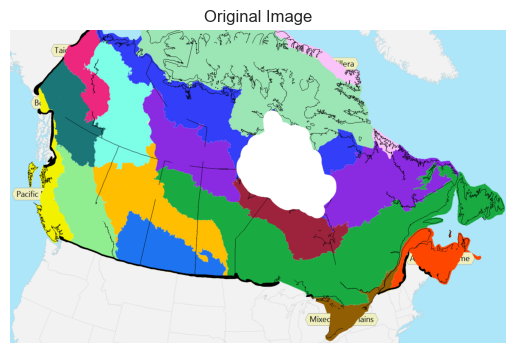

In [3]:
image = 'Fig1.3.png'
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #read in image

#show original image
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

- Region 1: (145, 94, 3)
    - Mixedwood Plains, lower Ontario 
- Region 2: (144, 238, 144)
    - Montane Cordillera, central BC
- Region 3: (27, 118, 119)
    - Boreal Cordillera, upper BC
- Region 4: (255, 70, 0)
    - Atlantic Maritime, Nova Scotia
- Region 5: (138, 43, 226)
    - First clustered region
    - Taiga Shield, upper Quebec and lower Nunavut
- Region 6: (157, 35, 60)
    - Hudson Plains, upper Ontario
- Region 7: (30, 116, 240)
    - Prairies, lower Saskatchewan, Alberta, and Manitoba
- Region 8: (255, 190, 0)
    - Boreal Plains, mid Saskatchewan, Alberta, and Manitoba
- Region 9: (124, 254, 231)
    - Taiga Plains, Northwest Territories
- Region 10: (236, 39, 125)
    - Southern Arctic, Yukon
- Region 11: (26, 170, 66)
    - Boreal Shield, mid Ontario, Quebec, Manitoba
- Region 12: (242, 242, 0)  
    - Pacific Maritime, western BC
- Region 13: (50, 62, 247)
    - Southern Arctic, upper Nunavut, and NWT
- Region 15: (156, 229, 180)
    - Northern Arctic, Yukon
- Region 16: (250, 195, 250)
    - Arctic Cordillera, upper Nunavut


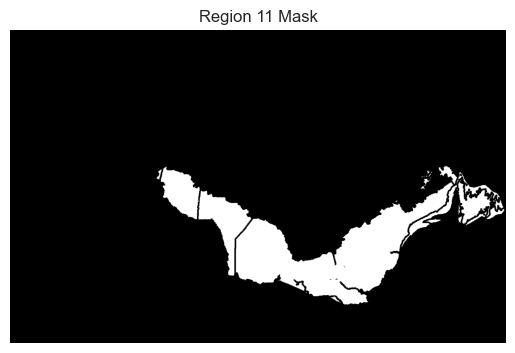

In [4]:
#assign regions based on RGB colour scheme
regions_rgba = {
    "Region 1": (145, 94, 3),
    "Region 2": (144, 238, 144),
    "Region 3": (27, 118, 119),
    "Region 4": (255, 70, 0),
    "Region 5": (138, 43, 226),
    "Region 6": (157, 35, 60),
    "Region 7": (30, 116, 240),
    "Region 8": (255, 190, 0),
    "Region 9": (124, 254, 231),
    "Region 10": (236,39,125),
    "Region 11": (26, 170, 66),
    "Region 12": (242, 242, 0),
    "Region 13": (50, 62, 247),
    "Region 14": (156, 229, 180),
    "Region 15": (250, 195, 250),
}


#Region mask dictionary to store region masks
region_masks = {}
max_tolerance = 50
tolerance_step = 0.5


#Create a mask for each region
for region, color in regions_rgba.items():
    
    tolerance = 0
    mask = None
    
    while tolerance <= max_tolerance:
        
        #find and mask color in image. Adjust color in order to find region of image to mask
        mask = cv2.inRange(image, np.array(color)-tolerance, np.array(color)+tolerance)
        
        if cv2.countNonZero(mask) > 0:
            break
            
        tolerance += tolerance_step
    
    #assign a region to a mask
    region_masks[region] = mask
    
#Visualize mask
plt.imshow(region_masks['Region 11'],cmap="gray")
plt.title("Region 11 Mask")
plt.axis("off")
plt.show()
    


> Now that we have masked our image and determined the areas where each colour/region is present we can continue on to assign latitude and longitude coordinates to each mask. The process I've decided to use is to create square boxes that represent the longitude and latitude maximums and minimums for each region. *As part of my research I've realized that create polygons to represent each region would have been the better approach*.
> 

> To start we assign the non-continguous regions. This is done by creating density based clusters. The reason I've done this is to avoid the seperated region covering latitude and longitude values that aren't included in its region. For example, region 5, the Taiga shield ranges from the north-eastern parts of quebec to the NorthWest Territories. This has to be split into two to avoid all points be classified as region 5, as they are in its max and min points.

> This section utilizes the function pixel_to_loca which will assign latitude and longitude coordinates to each pixel in a mask. It does this by first defining the space of the image, the min and max latitudes that represent the geographic bounds of Canada. For each region it then returns all the latitude and longitudes, and determines the maximum and minimum. It follows by adding the region (and part for clustered regions) and it's maximum and minimum latitude and longitude to a dictionary which is then made into a dataframe for later use.

In [5]:
#Defining the geographic bounds of the image. Roughly defined as the longitude latitude maximums and minimums for Canada.
min_lat, max_lat = 42.0, 83
min_lon, max_lon = -141.0, -53.0



# Get image dimensions
height, width, _ = image.shape


#set region bounds dictionary for regions that are separated and need to be clustered
region_bounds_cluster = {}
#set region bounds for complete regions
region_bounds = {}


for region, mask in region_masks.items():
    
    #for regions that are separated and are not one continguous piece
    if region in ['Region 5', 'Region 13', 'Region 16']:       
        #turn coords into a 2d array
        coords = np.column_stack(np.where(mask > 0))
        
        #error handling for missing coords
        if len(coords) == 0:
            print(f"Region: {region} does not have valid pixels")
            continue
            
        #assign latitude and longitudes to masks utilizing function
        lon_1, lat_1 = pixel_to_loca(coords[:, 0], coords[:, 1])
        
        #turn points into 2D array
        points = np.column_stack((lon_1, lat_1))
        
        #cluster points to find two clusters on image
        clustering = DBSCAN(eps = 1, min_samples = 2).fit(points)
        unique_labels = set(clustering.labels_)
        
       # Store bounds for each cluster, designed to store multiple parts for each split region
        cluster_bounds = []
        for label in unique_labels:
            if label == -1:
                continue
            #assign cluster points
            cluster_points = points[clustering.labels_ == label]
            
            #assign lat and lon minimums and maximums for clusters
            lat_min_cluster = cluster_points[:, 0].min()
            lat_max_cluster = cluster_points[:, 0].max()
            lon_min_cluster = cluster_points[:, 1].min()
            lon_max_cluster = cluster_points[:, 1].max()
            
            #append the cluster_bounds list for cluster max and mins
            cluster_bounds.append({
                "lon_min": lon_min_cluster, "lat_min": lat_min_cluster,
                "lon_max": lon_max_cluster, "lat_max": lat_max_cluster,
            })
    
        region_bounds_cluster[region] = cluster_bounds
    
    else:
        
        #more straightforward contiguous assignment of latitude and longitude
        y_coords, x_coords = np.where(mask>0)
            
        if len(x_coords) == 0 or len(y_coords) == 0:
            print(f"Region: {region} does not have valid pixels")
            
        lats = []
        lons = []
            
        for x, y in zip(x_coords, y_coords):
            #adjust x_coords and y_coords to long and lat defined by image
            lat, lon = pixel_to_loca(x, y)
            lons.append(lon)
            lats.append(lat)
                      
            
        #determine lat and longitude max and mins
        lat_min, lat_max = min(lats), max(lats)
        lon_min, lon_max = min(lons), max(lons)
            
        region_bounds[region] = {
            "min_lat": lat_min,
            "max_lat": lat_max,
            "min_lon": lon_min,
            "max_lon": lon_max,
            }
            
#for each region, assign minimum and maximums from region_bounds dict          
region_limits_df = pd.DataFrame.from_dict(
    {region: {"min_lat": bounds["min_lat"],
              "max_lat": bounds["max_lat"],
              "min_lon": bounds["min_lon"],
              "max_lon": bounds["max_lon"],} 
     for region, bounds in region_bounds.items()},
    orient="index"
)

region_limits = []

#for each region, assign minimum and maximums from cluster_bounds dict, split multiple regions into separate parts
for region, bounds in region_bounds_cluster.items():
    for part_id, cluster in enumerate(bounds, start=1):
        row = {
            "region": region,
            "part": part_id,
            "min_lon": cluster["lon_min"],
            "max_lon": cluster["lon_max"],
            "min_lat": cluster["lat_min"],
            "max_lat": cluster["lat_max"],
        }
        region_limits.append(row)
    
region_limits_clusters_df = pd.DataFrame(region_limits).set_index("region")
region_limits_df = pd.concat([region_limits_df, region_limits_clusters_df])

    
display(region_limits_df)


,min_lat,max_lat,min_lon,max_lon,part
Region 1,42.419437,52.241262,-86.598277,-72.192246,NaN
Region 2,53.184996,67.830350,-133.323102,-122.044696,NaN
Region 3,65.104007,78.875533,-135.597738,-124.224556,NaN
Region 4,49.235294,56.994885,-73.329564,-57.549273,NaN
Region 6,52.940324,63.426257,-101.430802,-81.101239,NaN
Region 7,50.878090,59.127025,-122.234249,-102.899838,NaN
Region 8,48.885763,68.005115,-126.167474,-73.613893,NaN
Region 9,64.789429,81.287298,-127.778675,-115.742057,NaN
Region 10,70.906223,83.000000,-131.522348,-123.418955,NaN
Region 11,47.033248,65.138960,-114.983845,-53.379106,NaN


> I narrow down the data points I want to examine here. I've decided to study fires post 2012. Which is the year that climate change began to pick up again following several years of slowed increases in temperature.
> https://www.climate.gov/news-features/climate-qa/did-global-warming-stop-1998#:~:text=No%2C%20but%20thanks%20to%20natural,decades%20leading%20up%20to%20it.

In [6]:
#keep only data post 2012
fire_data = fire_data.query('YEAR > 2012')
#replace white space with nan
fire_data = fire_data.replace(' ', np.nan)
fire_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 63601 entries, 0 to 436563
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         63601 non-null  int64  
 1   NFDBFIREID  63601 non-null  object 
 2   SRC_AGENCY  63601 non-null  object 
 3   NAT_PARK    1350 non-null   object 
 4   FIRE_ID     63601 non-null  object 
 5   FIRENAME    13469 non-null  object 
 6   LATITUDE    63601 non-null  float64
 7   LONGITUDE   63601 non-null  float64
 8   YEAR        63601 non-null  int64  
 9   MONTH       63601 non-null  int64  
 10  DAY         63601 non-null  int64  
 11  REP_DATE    63300 non-null  object 
 12  ATTK_DATE   202 non-null    object 
 13  OUT_DATE    40822 non-null  object 
 14  SIZE_HA     63601 non-null  float64
 15  CAUSE       63601 non-null  object 
 16  CAUSE2      63601 non-null  object 
 17  FIRE_TYPE   45137 non-null  object 
 18  RESPONSE    18564 non-null  object 
 19  PROTZONE    11967 non-null  o

# Section 3: Data Transformation and Feature Engineering

> In this section I assign the regions for each instance and pull in relevant weather data. 
>
> I obtain the region for each instance by applying the find_range function defined above to search for a particular latitude and longitude, inclusive of tolerance, in the region limits dataframe. If found we assign the region to the row. If not found, 'nothing is assigned'. 

In [7]:
#Applying regions to data utilizing find_range function
fire_data['Region'] = fire_data.apply(lambda row: find_range(row['LATITUDE'], row['LONGITUDE'], region_limits_df), axis=1)
display(fire_data)

,FID,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,OUT_DATE,SIZE_HA,CAUSE,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,Region
0,0,BC-2023-2023-C23369,BC,NaN,2023-C23369,C23369,51.819700,-122.072900,2023,9,27,2023-09-27 00:00:00,NaN,2023-09-28 00:00:00,0.010,H,H,Fire,FUL,NaN,NaN,NE of Alkali Creek,NaN,NaN,2024-05-06 00:00:00,Region 7
1,1,BC-2023-2023-R50580,BC,NaN,2023-R50580,KITSELAS ROAD,54.569200,-128.461100,2023,6,2,2023-06-02 00:00:00,NaN,2023-06-10 00:00:00,1.400,H,H,Fire,FUL,NaN,NaN,N of 12km on Kitselas Rd,NaN,NaN,2024-05-06 00:00:00,Region 2
2,2,BC-2023-2023-K40937,BC,NaN,2023-K40937,NaN,50.116600,-119.273800,2023,6,27,2023-06-27 00:00:00,NaN,2023-06-27 00:00:00,0.009,H,H,Fire,FUL,NaN,NaN,Oyama Lake,NaN,NaN,2024-05-06 00:00:00,Region 8
3,3,BC-2023-2023-R10108,BC,NaN,2023-R10108,LAUREL ROAD,54.227000,-125.654300,2023,4,28,2023-04-28 00:00:00,NaN,2023-05-01 00:00:00,1.100,H,H,Fire,FUL,NaN,NaN,Laurel Rd,NaN,NaN,2024-05-06 00:00:00,Region 2
4,4,BC-2023-2023-K50058,BC,NaN,2023-K50058,Campbell Mountain,49.518700,-119.534800,2023,4,17,2023-04-17 00:00:00,NaN,2023-04-18 00:00:00,0.009,H,H,Fire,FUL,NaN,NaN,Campbell Mountain,NaN,NaN,2024-05-06 00:00:00,Region 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436559,436559,AB-2023-PWF016,AB,NaN,PWF016,NaN,56.456850,-116.077467,2023,4,27,2023-04-27 00:00:00,NaN,NaN,0.410,H,H,Surface,NaN,NaN,NaN,Indian Reservation,NaN,NaN,2024-06-13 00:00:00,Region 7
436560,436560,AB-2023-SWF055,AB,NaN,SWF055,NaN,54.966217,-115.570850,2023,5,3,2023-05-03 00:00:00,NaN,NaN,0.100,H,H,Surface,NaN,NaN,NaN,Provincial Land,NaN,NaN,2024-06-13 00:00:00,Region 7
436561,436561,AB-2023-GWF031,AB,NaN,GWF031,NaN,55.350571,-117.119320,2023,5,21,2023-05-21 00:00:00,NaN,NaN,0.300,N,N,Ground,NaN,NaN,NaN,Provincial Land,NaN,NaN,2024-06-13 00:00:00,Region 7
436562,436562,AB-2023-PWF128,AB,NaN,PWF128,NaN,56.177685,-116.799293,2023,8,2,2023-08-02 00:00:00,NaN,NaN,0.010,H,H,Surface,NaN,NaN,NaN,Provincial Land,NaN,NaN,2024-06-13 00:00:00,Region 7


> Examining the total regions we can see that only 194 have not been assigned correctly. These regions will now be dealt with according to the agency that reported them. I'm making the assumption that the agency reporting is where the fire is taking place. For national parks I look up in my current dataframe to determine what region was assigned to that national park previously and assign it to this instance. 
>
> I then drop whatever is remaining due to invalid or missing data. Including values in the column day as they represent incomplete data.

In [8]:
#understand the region count
print(fire_data.value_counts('Region'))


#check the agencies for the missing region to see if I can assign based on Province
missing_regions = fire_data[fire_data['Region'] == 'Unknown']
print(missing_regions.value_counts('SRC_AGENCY'))

#assignment based on province of reporting agency
for idx, row in fire_data.iterrows():
    if row['Region'] == 'Unknown':
        #NL entirely in region 11
        if row['SRC_AGENCY'] == 'NL':
            fire_data.loc[idx, 'Region'] = 11
        #take the mode for each region that is national park
        elif row['SRC_AGENCY'] == 'PC':
            nat_park_rows = fire_data[fire_data['NAT_PARK'] == row['NAT_PARK']]
            region = nat_park_rows['Region'].mode()
            if not region.empty:
                fire_data.loc[idx, 'Region'] = region[0]
        #else if it's empty just add mode in
        else:
            agency_rows = fire_data[fire_data['SRC_AGENCY'] == row['SRC_AGENCY']]
            region = agency_rows['Region'].mode()
            if not region.empty:
                fire_data.loc[idx, 'Region'] = region[0]

#Final missing rows are dropped as they don't contain latitude or longitude and have other invalid/missing data
fire_data = fire_data[fire_data['Region'] != 'Unknown']
#drop missing days
fire_data = fire_data[fire_data['DAY'] != 0]

Region
Region 7     21220
Region 8     19544
Region 11     7117
Region 1      6656
Region 2      3953
Region 6      2739
Region 4       808
Region 12      644
Region 13      564
Unknown        194
Region 3       145
Region 5        17
Name: count, dtype: int64
SRC_AGENCY
PC    139
NL     53
NS      1
YT      1
Name: count, dtype: int64


In [9]:
#validate regions against SRC Agencies reporting. Roughly expected
print(fire_data.value_counts('SRC_AGENCY'))


SRC_AGENCY
BC    16919
AB    14079
ON     7682
QC     5551
SK     4766
MB     3880
NB     2808
NT     2303
NS     2027
PC     1314
YT     1090
NL      809
PE       35
Name: count, dtype: int64


In [10]:
#drop columns without predictive power
fire_data.drop(columns = ['NFDBFIREID', 'FIRE_ID', 'SRC_AGENCY', 'FIRENAME', 'ATTK_DATE', 'PRESCRIBED', 'MORE_INFO', 'CFS_NOTE1', 'CFS_NOTE2', 'ACQ_DATE'], inplace=True)

> Additional data transformation as involved adjusting the national park column to be binary. 1, indicating the fire took place in a national park, 0 if it did not.
>
> I then drop cause 2 as it is fundamentally similar to cause 1, but doesn't include prescribed burns.

In [11]:
categorical_col = ['NAT_PARK', 'CAUSE', 'CAUSE2', 'FIRE_TYPE', 'RESPONSE']

#check through values of categorical columns
for col in categorical_col:
    print(fire_data.value_counts(col))


#adjust national park to be a binary variable indicating whether or not it took place in national park    
fire_data['NAT_PARK BINARY'] = fire_data['NAT_PARK'].apply(lambda x: 0 if pd.isna(x) else 1)
fire_data.drop(columns = ['NAT_PARK'], inplace=True)

#drop cause 2 as it is fundamentally similar to cause without prescribed burns
print(fire_data.groupby('CAUSE')['CAUSE2'].value_counts())
#retaining cause as it includes prescribed burns
fire_data.drop(columns = ['CAUSE2'], inplace=True)






NAT_PARK
PC-WB       295
PC-BA       259
PC-JA       117
PC-KO        69
PC-GL        62
PC-NA        59
PC-GR        49
PC-WL        45
PC-RE        44
PC-PA        39
PC-RM        37
PC-TN        34
PC-LM        34
PC-YO        30
PC-PP        27
PC-EI        16
PC-PU        15
PC-TI        12
PC-TH        10
PC-WP         9
PC-KE         7
PC-PR         6
PC-CB         4
PC-GI         4
PC-FO         4
PC-FU         3
PC-WAFU       3
PC-RE-GL      3
PC-KG         3
PC-VU         3
PC-KL         2
PC-BP         2
PC-MM         2
PC-NI         2
PC-SY         1
PC-SE         1
PC-GF         1
PC-NC         1
Name: count, dtype: int64
CAUSE
H       31748
N       29630
U        1711
H-PB      174
Name: count, dtype: int64
CAUSE2
H    31922
N    29630
U     1711
Name: count, dtype: int64
FIRE_TYPE
Fire                16919
Wildfire             8497
IFR                  7654
Surface              5920
Ground               1858
Forest               1335
Grass                1091
Crown      

> The weather data function is called here using our fire_data dataframe to go through each latitude and longitude and year-month group and find 7-day average temperatures. These temperatures and weather statistics are then assigned to each instance.

> The decision to include weather data follows along with the following environmental features believed to impact fire size and occurrence. 
>
- Summary of Leading Temperature Effects
- Hot and dry weather reduces moisture content in vegetation, increasing flammability.
- Heatwaves and low humidity are common precursors to wildfires.
- Wind patterns driven by temperature gradients can spread fire more quickly.
- Temperature inversions can lead to dry, stagnant air that exacerbates fire risk.

In [12]:
#assign weather data by passing dictionary
grouped_data = weather_data(fire_data)
display(grouped_data)
fire_data = grouped_data.copy()

,FID,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,OUT_DATE,SIZE_HA,CAUSE,FIRE_TYPE,RESPONSE,PROTZONE,Region,NAT_PARK BINARY,lat_rounded,lon_rounded,Year-Month,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
0,0,51.819700,-122.072900,2023,9,27,2023-09-27 00:00:00,2023-09-28 00:00:00,0.010,H,Fire,FUL,NaN,Region 7,0,52,-122,2023-09-01,17.1375,10.5875,23.4750,0.0375,NaN,7.6125,NaN,1018.1625
1,0,51.819700,-122.072900,2023,9,27,2023-09-27 00:00:00,2023-09-28 00:00:00,0.010,H,Fire,FUL,NaN,Region 7,0,52,-122,2023-09-01,17.1375,10.5875,23.4750,0.0375,NaN,7.6125,NaN,1018.1625
2,1,54.569200,-128.461100,2023,6,2,2023-06-02 00:00:00,2023-06-10 00:00:00,1.400,H,Fire,FUL,NaN,Region 2,0,54,-128,2023-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,50.116600,-119.273800,2023,6,27,2023-06-27 00:00:00,2023-06-27 00:00:00,0.009,H,Fire,FUL,NaN,Region 8,0,50,-120,2023-06-01,17.5875,8.7500,25.1875,0.0000,NaN,9.9875,NaN,1010.8125
4,3,54.227000,-125.654300,2023,4,28,2023-04-28 00:00:00,2023-05-01 00:00:00,1.100,H,Fire,FUL,NaN,Region 2,0,54,-126,2023-04-01,-1.7125,-6.1500,2.9500,0.4500,NaN,8.0375,NaN,1015.5375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72203,436561,55.350571,-117.119320,2023,5,21,2023-05-21 00:00:00,NaN,0.300,N,Ground,NaN,NaN,Region 7,0,56,-118,2023-05-01,8.4250,1.4125,15.8625,0.3625,NaN,13.8250,43.0,1012.9250
72204,436561,55.350571,-117.119320,2023,5,21,2023-05-21 00:00:00,NaN,0.300,N,Ground,NaN,NaN,Region 7,0,56,-118,2023-05-01,8.4250,1.4125,15.8625,0.3625,NaN,13.8250,43.0,1012.9250
72205,436562,56.177685,-116.799293,2023,8,2,2023-08-02 00:00:00,NaN,0.010,H,Surface,NaN,NaN,Region 7,0,56,-116,2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72206,436563,56.979133,-117.324533,2023,10,15,2023-10-15 00:00:00,NaN,0.010,H,Surface,NaN,NaN,Region 7,0,56,-118,2023-10-01,8.9625,4.0875,14.7625,0.8000,NaN,11.1000,163.8,1011.2125


In [13]:
grouped_data.describe()

,FID,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,SIZE_HA,NAT_PARK BINARY,lat_rounded,lon_rounded,Year-Month,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
count,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208,36498.000000,36513.000000,37038.000000,34405.000000,15466.000000,28879.000000,16880.000000,27856.000000
mean,219568.032323,52.550829,-104.234852,2018.018682,6.532185,15.522006,772.913527,0.020967,52.578080,-104.228507,2018-06-23 22:17:22.588079104,12.741980,6.326209,19.010543,1.512250,29.177390,10.938291,72.335013,1014.894084
min,0.000000,0.000000,-188.075000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-188.000000,2013-01-01 00:00:00,-25.862500,-31.787500,-20.900000,0.000000,0.000000,1.800000,0.000000,999.542857
25%,152182.750000,49.576400,-119.019925,2015.000000,5.000000,8.000000,0.010000,0.000000,50.000000,-120.000000,2015-07-01 00:00:00,6.825000,0.875000,12.762500,0.187500,0.000000,8.375000,39.250000,1012.500000
50%,208207.500000,52.121200,-114.084833,2018.000000,7.000000,15.000000,0.150000,0.000000,52.000000,-114.000000,2018-06-01 00:00:00,14.512500,8.075000,20.362500,0.700000,0.000000,10.525000,46.714286,1014.562500
75%,322138.250000,55.447240,-91.997750,2021.000000,8.000000,23.000000,1.600000,0.000000,56.000000,-92.000000,2021-07-01 00:00:00,18.512500,11.937500,25.250000,2.100000,2.857143,13.325000,108.450000,1017.237500
max,436563.000000,69.571633,116.188000,2023.000000,12.000000,31.000000,885388.214200,1.000000,70.000000,116.000000,2023-12-01 00:00:00,30.425000,23.312500,37.500000,31.900000,1010.000000,59.900000,306.000000,1037.087500
std,131377.503592,4.862746,20.793390,3.245683,1.558864,9.006794,11331.565730,0.143275,4.860999,20.830076,NaN,7.653069,7.261418,8.384309,2.088632,94.441750,4.267514,48.418043,4.302560


> Additional data cleaning performed. Monitored responses under different acronyms adjusted to a general monitored response. Created a feature to determine the amount of time from start date of the fire to when the fire was put out. Dropped irrelevant columns that represent placeholders or are text with no standardized values. Little value to be generated from these. I one-hot encode each of the categorical variables that I will be including going forward and I ensure that empty data for temperature statistics are replaced with 0. My assumption here is that the missing data is not missing, it is simply that there was none of that particular weather effect. For example, no precipitation would return null, but is actually a value of 0.

In [14]:
#Replace MDP and MNP with monitored fire response
fire_data['RESPONSE'] = fire_data['RESPONSE'].replace(['MDP', 'MNP'], 'MON')

#categorical columns to one-hot encode
categorical_col = ['CAUSE', 'FIRE_TYPE', 'RESPONSE', 'PROTZONE']

#check value counts
for col in categorical_col:
    print(fire_data.value_counts(col))
    

#get report data
fire_data['Report Date'] = pd.to_datetime(fire_data[['YEAR', 'MONTH', 'DAY']])
#transform out date to date time
fire_data['Out Date'] = pd.to_datetime(fire_data['OUT_DATE'])
#calculate duration for clustering
fire_data['Duration'] = (fire_data['Out Date'] - fire_data['Report Date']).dt.days

#drop unnecessary columns
fire_data.drop(columns = ['PROTZONE', 'LATITUDE', 'LONGITUDE', 'REP_DATE', 'OUT_DATE', 'lat_rounded', 'lon_rounded', 'Year-Month', 'YEAR', 'DAY', 'Report Date', 'Out Date', 'snow', 'FID', 'FIRE_TYPE'], inplace=True)

#one-hot encode categorical columns
fire_data_encoded = pd.get_dummies(fire_data, columns = ['CAUSE', 'Region', 'RESPONSE', 'MONTH'], drop_first=True, dtype=int)

#adjust so that any missing values in weather data that exists has nan replaced with zero. With weather data available and missing values, we can assume there is none of that field to be measured or, value = 0
temp_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wpgt','pres']
for column in temp_columns:
    for column_1 in temp_columns:
        if column == column_1:
            continue
        else:
             fire_data_encoded.loc[fire_data_encoded[column_1].notna() & fire_data_encoded[column].isna(), column] = 0


display(fire_data_encoded)

CAUSE
H       35668
N       34420
U        1932
H-PB      188
Name: count, dtype: int64
FIRE_TYPE
Fire                19377
Wildfire            10284
IFR                  8607
Surface              7124
Ground               2196
Forest               1335
Grass                1091
Crown                 483
Type 5                271
Other                 267
1                     221
99                    154
Mutual Aid            147
Dump                  115
Req For Assist         91
2                      76
Request For Ass*       61
4                      35
PB                     23
5                      22
Prescribed Burn        22
Type 4                 18
Type 3                 17
OFR                     9
Type 1                  4
Type 2                  2
3                       1
Name: count, dtype: int64
RESPONSE
FUL    16292
MON     3632
MOD     1162
Name: count, dtype: int64
PROTZONE
Intensive                    4430
FUL-R (High Priority)        1015
MON-Monitored          

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,Duration,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 3,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1.400,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.009,0,17.5875,8.7500,25.1875,0.0000,9.9875,0.0,1010.8125,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.100,0,-1.7125,-6.1500,2.9500,0.4500,8.0375,0.0,1015.5375,3.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72203,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72204,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72205,0.010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
72206,0.010,0,8.9625,4.0875,14.7625,0.8000,11.1000,163.8,1011.2125,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


> Examination of the current table state shows that we have our temperatures in and missing data for rows with data has been replaced with 0

In [15]:
fire_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72208 entries, 0 to 72207
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SIZE_HA           72208 non-null  float64
 1   NAT_PARK BINARY   72208 non-null  int64  
 2   tavg              37108 non-null  float64
 3   tmin              37108 non-null  float64
 4   tmax              37108 non-null  float64
 5   prcp              37108 non-null  float64
 6   wspd              37108 non-null  float64
 7   wpgt              37108 non-null  float64
 8   pres              37108 non-null  float64
 9   Duration          46078 non-null  float64
 10  CAUSE_H-PB        72208 non-null  int32  
 11  CAUSE_N           72208 non-null  int32  
 12  CAUSE_U           72208 non-null  int32  
 13  Region_Region 1   72208 non-null  int32  
 14  Region_Region 11  72208 non-null  int32  
 15  Region_Region 12  72208 non-null  int32  
 16  Region_Region 13  72208 non-null  int32 

> Quick examination to understand my target variable. Seems to be very skewed with data primarily focused on small fires <1 hector burned. Likely need to consider utilizing logistic regression to help minimize the effects of skewing and emmploy algorithms that can manage skewed and noisy data appropriately.

In [16]:
fire_data_encoded['SIZE_HA'].describe()

count     72208.000000
mean        772.913527
std       11331.565730
min           0.000000
25%           0.010000
50%           0.150000
75%           1.600000
max      885388.214200
Name: SIZE_HA, dtype: float64

> Quick breakdown of each numerical category indicates that we have ~37k rows of data with complete temperature information to be used in our analysis. Our target is still skewed in distribution. Many of our temperature continuous variables are also not normally distributed. Given the distribution and values of my predictors I will be using min max scaling. I will also logarithmically scale my target variable for data exploration as it will help to understand the patterns and relationships in my data

In [17]:
fire_data_encoded.describe()

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,Duration,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 3,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
count,72208.000000,72208.000000,37108.000000,37108.000000,37108.000000,37108.000000,37108.000000,37108.000000,37108.000000,46078.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000,72208.000000
mean,772.913527,0.020967,12.532521,6.224773,18.974682,1.402096,8.512636,32.904361,761.854307,9.501866,0.002604,0.476678,0.026756,0.093826,0.103313,0.007561,0.007008,0.061724,0.001883,0.013101,0.000235,0.044593,0.358880,0.307140,0.016092,0.050299,0.000817,0.008739,0.083453,0.199119,0.172446,0.255401,0.197430,0.050784,0.024526,0.005152,0.001080
std,11331.565730,0.143275,7.760913,7.246665,8.416918,2.049162,5.901038,48.619328,439.088301,37.847840,0.050959,0.499459,0.161371,0.291589,0.304369,0.086628,0.083418,0.240656,0.043358,0.113708,0.015342,0.206411,0.479675,0.461311,0.125832,0.218563,0.028573,0.093072,0.276568,0.399341,0.377770,0.436089,0.398062,0.219558,0.154678,0.071591,0.032849
min,0.000000,0.000000,-25.862500,-31.787500,-20.900000,0.000000,0.000000,0.000000,0.000000,-6575.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.000000,6.585714,0.612500,12.737500,0.087500,3.425000,0.000000,1001.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150000,0.000000,14.275000,7.843750,20.350000,0.575000,9.450000,0.000000,1013.175000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.600000,0.000000,18.512500,11.850000,25.250000,1.875000,12.475000,44.428571,1016.287500,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,885388.214200,1.000000,30.425000,23.312500,37.500000,31.900000,59.900000,306.000000,1037.087500,458.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> Further narrow down my data to include only things I have complete data for. It would be possible to impute the remainder of the values but given >31k instances, I still have enough data to train a robust model.

In [18]:
#drop missing data. Still sufficient rows to complete model
fire_data_encoded = fire_data_encoded[fire_data_encoded['tavg'].notnull()]
display(fire_data_encoded)

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,Duration,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 3,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.009,0,17.5875,8.7500,25.1875,0.0000,9.9875,0.0,1010.8125,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.100,0,-1.7125,-6.1500,2.9500,0.4500,8.0375,0.0,1015.5375,3.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0.009,0,4.4125,-1.6500,11.3250,0.4750,9.2750,0.0,1014.8875,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72202,0.100,0,9.8125,2.1125,17.5250,0.5250,14.3625,0.0,1014.3250,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72203,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72204,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
72206,0.010,0,8.9625,4.0875,14.7625,0.8000,11.1000,163.8,1011.2125,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [19]:
#deal with 99th percentile outcome in target
upper_bound = fire_data_encoded['SIZE_HA'].quantile(0.99) # find the 99th percentile
fire_data_encoded = fire_data_encoded.loc[(fire_data_encoded['SIZE_HA'] <= upper_bound), :]

# Section 4: Exploratory Data Analysis

> In this section I perform my exploratory data analysis and scale my predictors for clustering. I am attempting to add additional features to provide value through clustering and explore the relationships between my predictors and my target.

In [20]:
correlation_matrix = fire_data_encoded.corr()
display(correlation_matrix)

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,Duration,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 3,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
SIZE_HA,1.000000,0.061596,0.041778,0.040211,0.040411,-0.026205,0.021019,0.011365,0.044261,0.400427,0.008948,0.119319,0.011399,-0.042635,-0.036934,0.031345,-0.004750,0.014695,NaN,-0.006203,-0.001360,0.026348,-0.007012,0.041928,0.084004,0.167193,-0.002733,-0.009112,-0.036617,-0.044491,0.033130,0.072341,-0.007662,-0.026042,-0.016483,-0.009658,-0.003838
NAT_PARK BINARY,0.061596,1.000000,-0.008500,-0.009725,-0.011517,-0.005098,0.040057,0.033997,0.048236,NaN,0.443785,0.023958,0.013195,-0.006674,-0.013240,-0.006786,-0.005502,-0.027044,NaN,-0.010578,-0.001253,-0.022672,-0.034515,0.072175,0.208383,0.008209,0.004619,0.034465,-0.006758,-0.018425,0.034174,0.004784,-0.017564,-0.010492,-0.000671,0.016208,-0.003964
tavg,0.041778,-0.008500,1.000000,0.969918,0.964310,-0.042167,-0.269718,-0.085213,-0.013459,0.119712,-0.057344,0.490915,-0.063011,-0.018227,-0.189465,0.009699,-0.001009,0.045676,NaN,-0.022209,0.005379,0.007336,-0.181360,0.297363,0.033980,0.061160,-0.057025,-0.245936,-0.498406,-0.455658,0.019759,0.400777,0.434447,0.117940,-0.034632,-0.090020,-0.070453
tmin,0.040211,-0.009725,0.969918,1.000000,0.920672,0.023326,-0.239618,-0.098863,-0.030539,0.115998,-0.055282,0.464510,-0.055640,-0.007774,-0.150563,-0.001557,0.023956,0.034846,NaN,-0.005410,0.006151,0.005175,-0.188874,0.273713,0.026008,0.078869,-0.053481,-0.249758,-0.504729,-0.459976,0.022748,0.411830,0.414287,0.135625,-0.026627,-0.079837,-0.065283
tmax,0.040411,-0.011517,0.964310,0.920672,1.000000,-0.120473,-0.327538,-0.082213,-0.045820,0.116683,-0.058348,0.504673,-0.061681,-0.044520,-0.238659,0.018112,-0.023039,0.050498,NaN,-0.038026,0.004411,-0.006004,-0.125375,0.298876,0.030279,0.049851,-0.059554,-0.239920,-0.504052,-0.444103,0.036264,0.386462,0.437338,0.102465,-0.036097,-0.100397,-0.074315
prcp,-0.026205,-0.005098,-0.042167,0.023326,-0.120473,1.000000,0.097499,0.021190,0.108325,-0.051065,-0.000571,-0.078398,-0.007028,0.208155,0.176567,-0.025478,0.007682,-0.027571,NaN,0.045204,-0.003605,0.022747,-0.162527,-0.100126,-0.014499,0.020361,-0.007629,-0.033965,0.031745,0.003598,0.020418,0.031873,-0.056700,0.002741,-0.025621,-0.009544,-0.016421
wspd,0.021019,0.040057,-0.269718,-0.239618,-0.327538,0.097499,1.000000,0.304335,0.597142,0.019291,0.031980,-0.169029,0.045667,-0.151626,0.281991,-0.001035,0.119432,-0.120658,NaN,0.018604,0.004404,0.091755,0.041098,-0.115486,0.014472,0.054641,0.003734,0.027477,0.089573,0.144305,0.008241,-0.091706,-0.139420,0.001578,0.002938,0.024698,0.024867
wpgt,0.011365,0.033997,-0.085213,-0.098863,-0.082213,0.021190,0.304335,1.000000,0.182470,0.027842,0.019771,-0.058854,0.001016,-0.100428,0.085128,0.018405,0.082845,-0.096396,NaN,0.040410,0.004288,-0.010334,0.042920,0.001308,0.039138,0.058107,-0.002834,0.008821,0.040076,0.021846,-0.005088,-0.024657,-0.032390,0.004246,0.009166,0.003029,0.022826
pres,0.044261,0.048236,-0.013459,-0.030539,-0.045820,0.108325,0.597142,0.182470,1.000000,0.044872,0.023466,0.028839,-0.008454,-0.007795,0.062557,-0.002050,0.006071,-0.139437,NaN,0.039260,0.006054,0.089727,-0.048469,0.033910,0.046052,0.064207,0.001266,-0.024900,-0.008815,-0.008605,-0.024236,0.001603,0.018586,0.018425,0.015943,0.027700,0.011540
Duration,0.400427,NaN,0.119712,0.115998,0.116683,-0.051065,0.019291,0.027842,0.044872,1.000000,-0.001587,0.289580,-0.002570,-0.106351,-0.103612,0.063775,0.026981,0.129664,NaN,-0.018715,0.017041,0.058914,-0.048467,0.148058,0.158807,0.435122,0.000893,0.017536,-0.069822,-0.150186,0.044619,0.147079,0.022388,-0.019453,0.012107,-0.001604,0.013939


> Duration is dropped because while the correlation is not high enough to indicate collinearity it conceptually explains the same thing. Duration leads to longer and larger fires, and vice versa. Consideration to add it back in eventually but for now it is dropped. Region 3 does not have any values and thus is dropped. Pressure is dropped prior to clustering 

In [21]:
fire_data_encoded.drop(columns = ['Duration', 'Region_Region 3'], inplace = True)
fire_data_encoded.describe()

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
count,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000,36737.000000
mean,65.478116,0.014209,12.510819,6.207794,18.947664,1.407111,8.499329,32.814074,760.495030,0.002940,0.418788,0.026431,0.123663,0.106868,0.003185,0.002096,0.048289,0.007703,0.000109,0.034434,0.337044,0.336609,0.010534,0.027193,0.000817,0.010698,0.095054,0.216458,0.149468,0.237826,0.202466,0.051964,0.027738,0.005417,0.001089
std,485.855991,0.118354,7.775698,7.260716,8.433099,2.055712,5.910780,48.534359,439.882608,0.054141,0.493367,0.160416,0.329201,0.308949,0.056345,0.045734,0.214380,0.087432,0.010434,0.182344,0.472707,0.472556,0.102096,0.162649,0.028565,0.102876,0.293294,0.411835,0.356554,0.425758,0.401843,0.221957,0.164223,0.073401,0.032980
min,0.000000,0.000000,-25.862500,-31.787500,-20.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.000000,6.550000,0.575000,12.687500,0.087500,3.425000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.100000,0.000000,14.262500,7.825000,20.325000,0.575000,9.437500,0.000000,1013.175000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,0.000000,18.512500,11.850000,25.250000,1.880000,12.475000,44.375000,1016.287500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7864.000000,1.000000,30.425000,23.312500,37.500000,31.900000,59.900000,306.000000,1037.087500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> Examining the correlation matrix I see that we have relatively low correlation between our predictors and our target. This represents a concern but we will continue.

> Below I begin the process of scaling my data. As mentioned I use min max scaler for my continuous variables as some are not normally distributed and it brings everything in line with the encoded categorical variables. Range of 0 to 1.

> I logarithmically scale my target variable for use in my EDA. It is easier to understand the relationship between my predictors and target by utilizing this. It will be transformed back for final models.

In [22]:
fire_data_orig = fire_data_encoded.copy()
#Identify numerical columns to scale
columns_to_scale = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wpgt', 'pres']
scaler = MinMaxScaler()

#Logarithmic scaling of target for EDA
fire_data_encoded['SIZE_HA'] = np.log1p(fire_data_encoded['SIZE_HA'])
#Min-max scaling of numerical columns
fire_data_encoded[columns_to_scale] = scaler.fit_transform(fire_data_encoded[columns_to_scale])
X = fire_data_encoded.drop(columns = 'SIZE_HA')


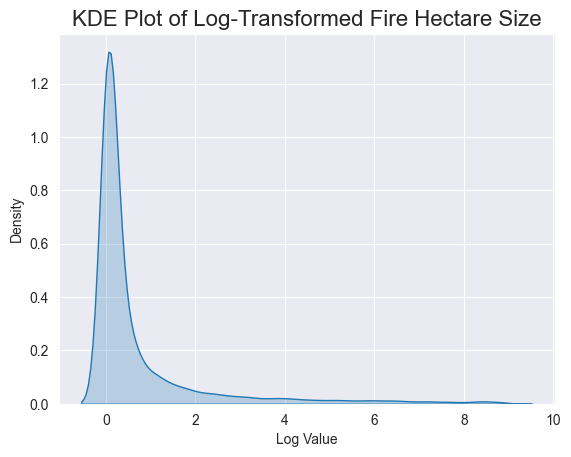

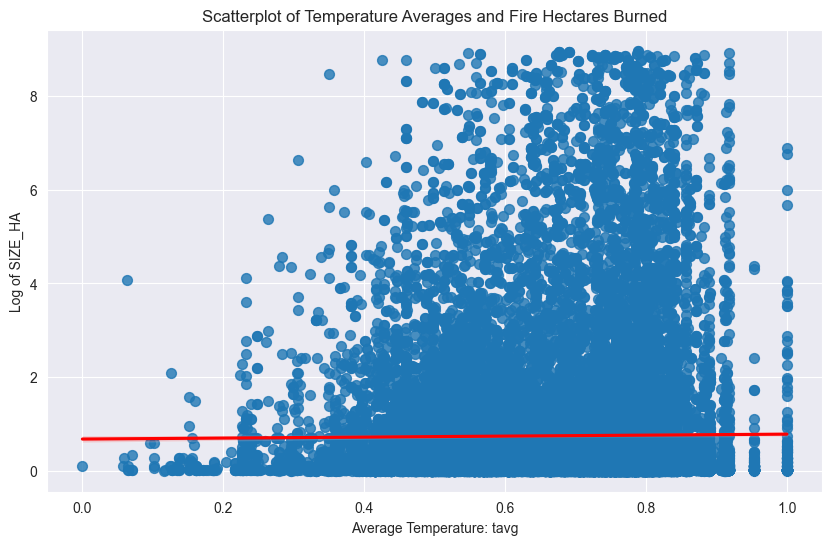

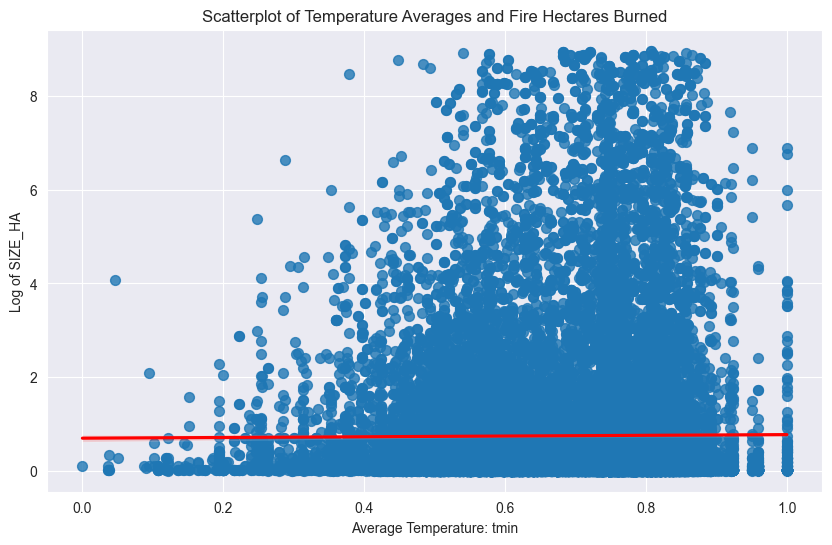

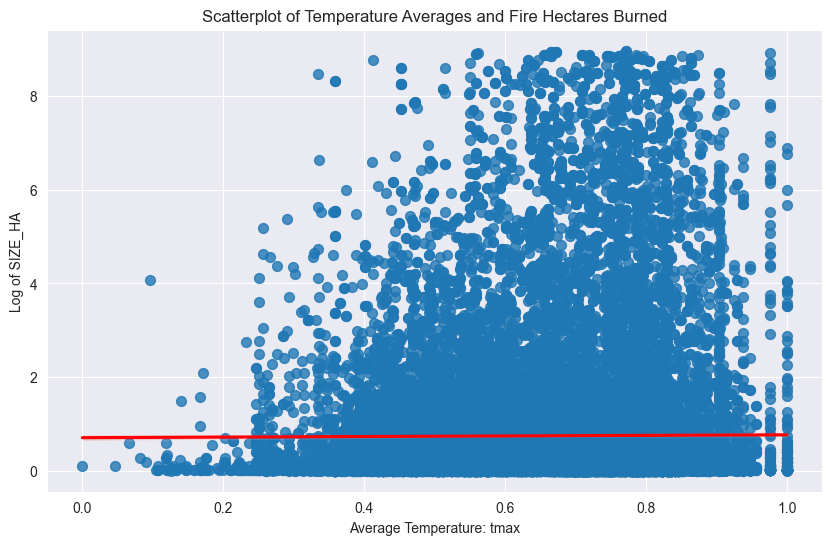

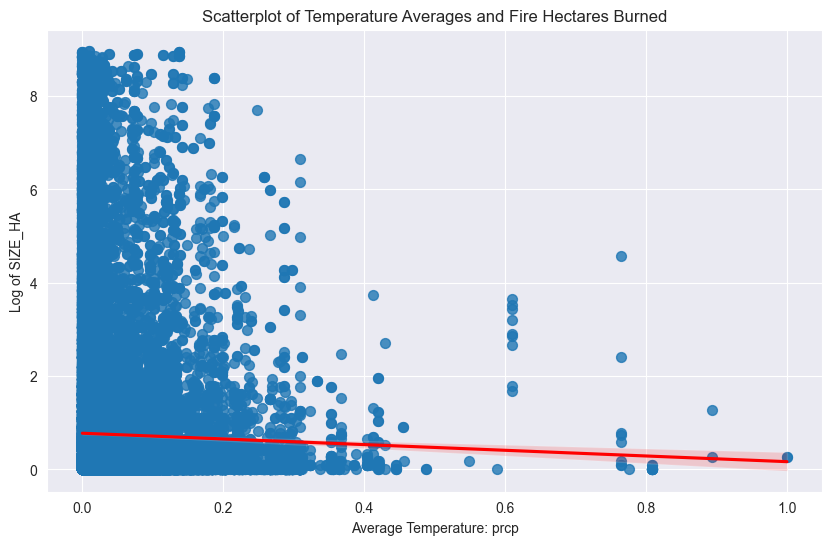

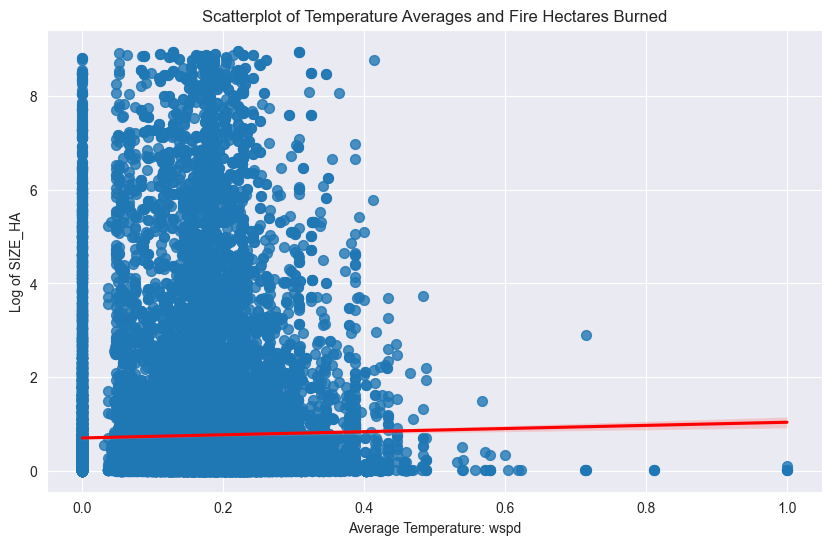

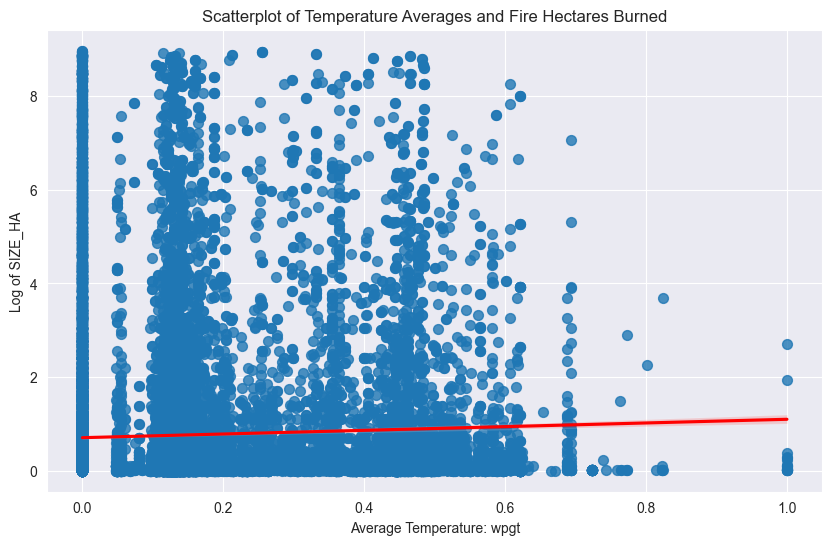

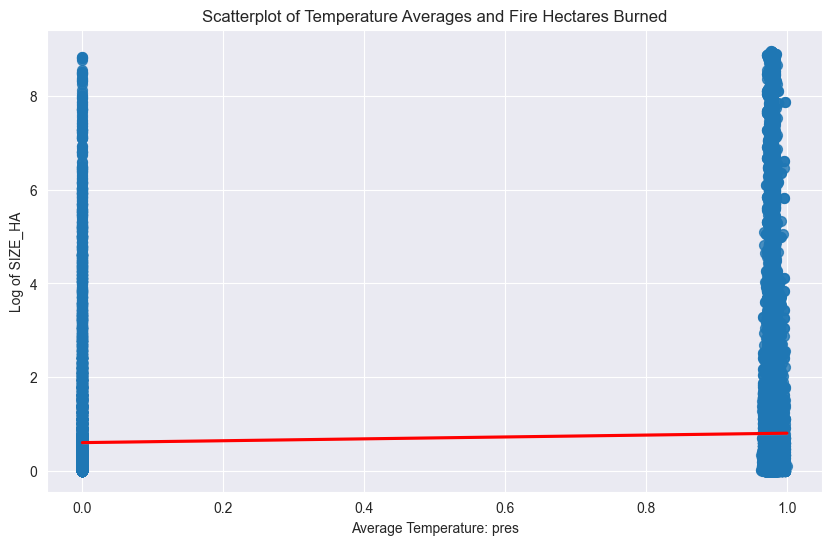

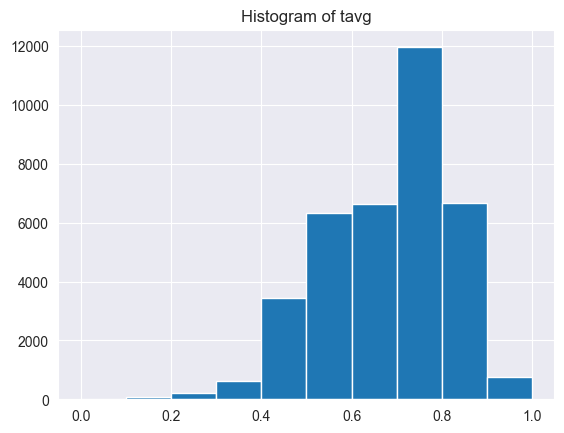

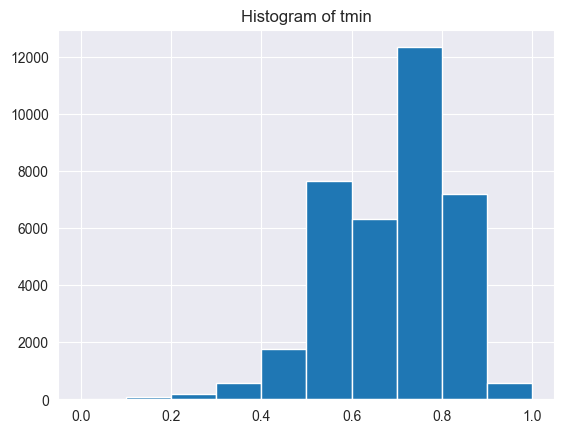

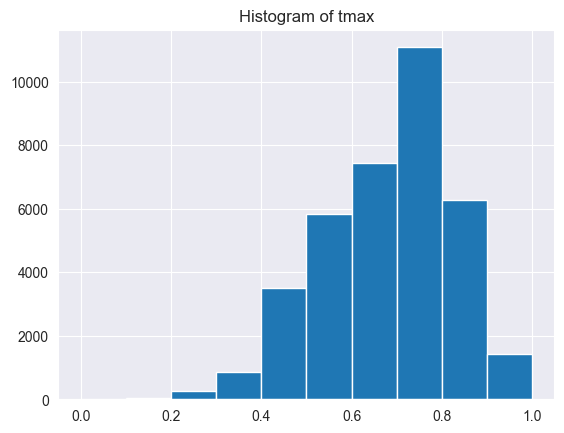

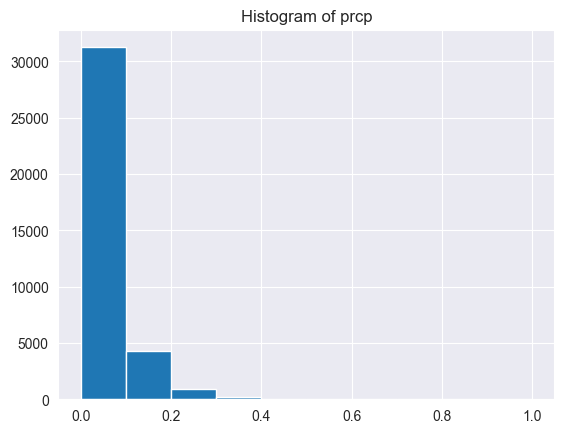

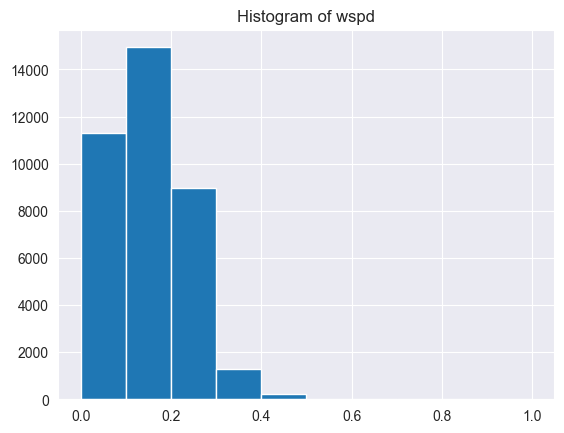

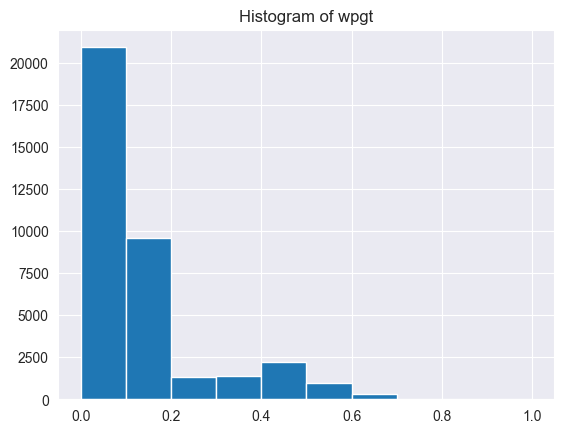

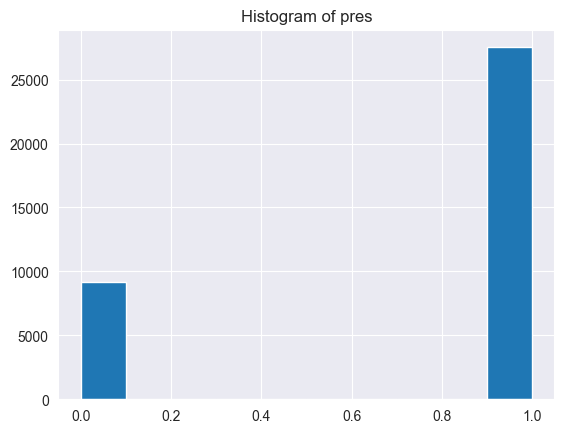

In [23]:
#Examine HDE plot to see the distribution of my target
sns.kdeplot(fire_data_encoded['SIZE_HA'], fill=True)
plt.title('KDE Plot of Log-Transformed Fire Hectare Size', fontsize=16)
plt.xlabel('Log Value')
plt.ylabel('Density')
plt.show()

#check relationship between weather measurements and target variable
temp_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wpgt', 'pres']
for column in temp_columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(x=fire_data_encoded[column], y=fire_data_encoded['SIZE_HA'], data=fire_data_encoded,
                scatter_kws={'s': 50}, line_kws={'color': 'red'})
    plt.title('Scatterplot of Temperature Averages and Fire Hectares Burned')
    plt.xlabel(f'Average Temperature: {column}')
    plt.ylabel('Log of SIZE_HA')
    plt.show()

#check distribution of weather measurements
num_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wpgt', 'pres']
for column in num_columns:
    plt.hist(fire_data_encoded[column])
    plt.title(f'Histogram of {column}')
    plt.show()

> In the first plot we can see how skewed the target variable is. Most of the instances lie on the lower end of the range. This indicates that most of the data in my dataset has hectors burned close to our minimum, while a few very large fires allow for tail to the right. 
> 
> In the second group of plots I examine the relationship between the size of a fire and the weather statistics. The logarithmic scaling of the target variable has resulted in muted trends line but there are still clear relationships between each of the weather predictors and the target. Perhaps the most clear relationships are between average wind speed, average maximum wind speeds, and precipitation and the target. Wind speed, both the maximum and average are positively related to the number of hectors burned, which conceptually agrees with our understanding of weather factors impacting fires from above. Precipitation is negatively related, which is anticipated.
> 
> I then examine each of my predictors individually to understand their distribution. As expected the temperature statistics are normally distributed while the other predictors are significantly more skewed.

# Section 5: Clustering and Outliers

> In this section I attempt to add additional predictive power to my model by clustering my data prior to running my supervised learning algorithms.

> I utilize TSNE for dimension reduction as it does well with non-linearity of this dataset. I reduce it down to two components so that I can assign clusters and visualize them. I tune for the correct number of clusters and find that three clusters performs the best. While no clear elbow is present the silhouette score clearly indicates three clusters is the best hyperparameter value.

[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\mackr\PycharmProjects\INSY 665\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\mackr\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\mackr\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mackr\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


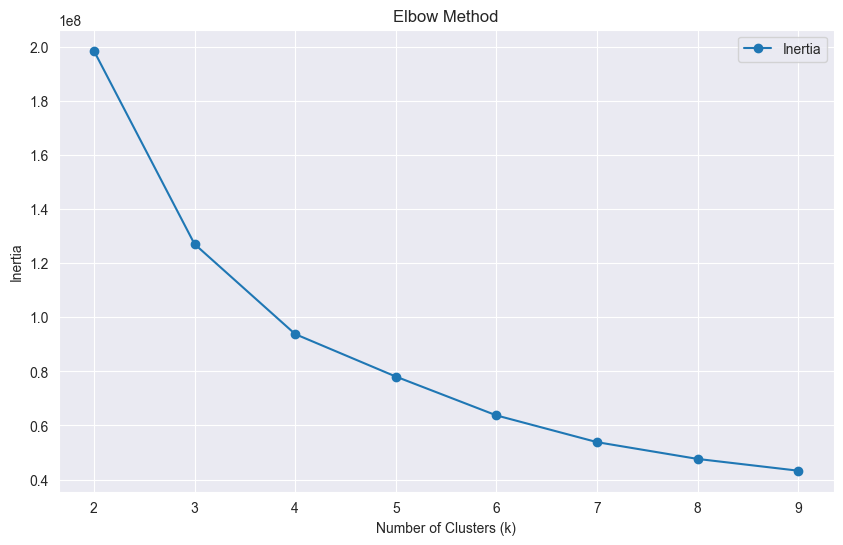

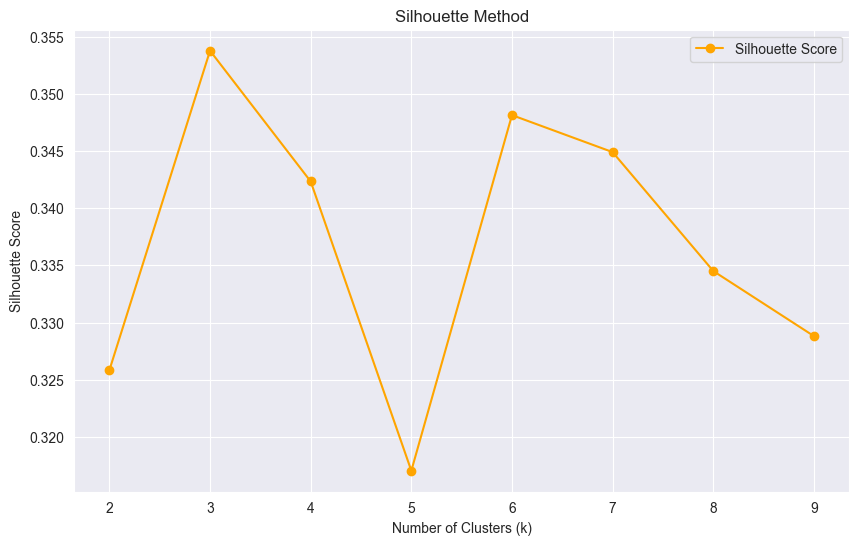

In [24]:
from sklearn.manifold import TSNE

#Utilize TSNE to reduce non-linear dataset into two dimensions for clustering
tsne = TSNE(n_components = 2, learning_rate = 'auto', init='random', perplexity=15, random_state = 42)
X_reduced = tsne.fit_transform(X)

silhouette_scores = []
inertia_values = []

#Check for optimal cluster count
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10, max_iter = 300)
    kmeans.fit(X_reduced)
    
    score=silhouette_score(X_reduced, kmeans.labels_)
    silhouette_scores.append(score)
    inertia_values.append(kmeans.inertia_)
    
#Inertia plot
plt.figure(figsize=(10, 6))
plt.plot(range(2,10), inertia_values, marker='o', label="Inertia")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.legend()
plt.show()
    
# Silhouette plot
plt.figure(figsize=(10, 6))
plt.plot(range(2,10), silhouette_scores, marker='o', color='orange', label="Silhouette Score")
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()
plt.show()

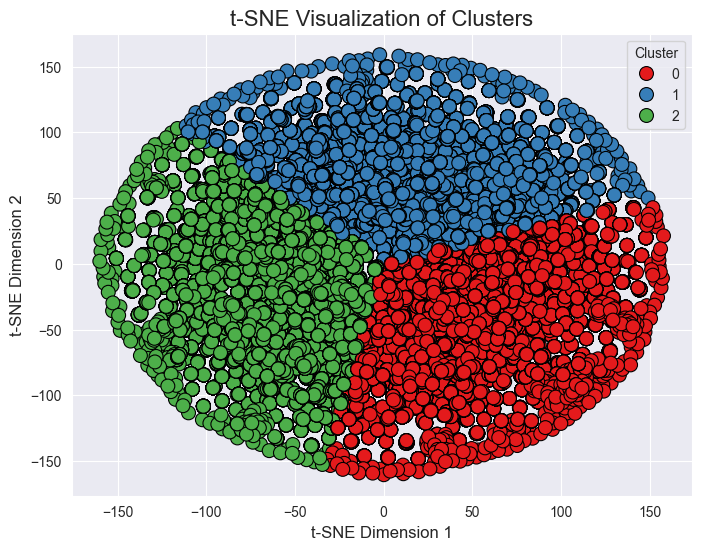

In [25]:
plt.show()
# Final K-means model on reduced dimensions
tsne_df = pd.DataFrame(X_reduced, columns=['t_SNE1', 't_SNE2'])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)  # Set desired n_clusters based on results
kmeans.fit(X_reduced)


# Add cluster labels to the dataset
tsne_df['cluster'] = kmeans.labels_

#Plot reduced dataset with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='t_SNE1', y='t_SNE2', hue='cluster', palette='Set1', s=100, edgecolor='black')
plt.title("t-SNE Visualization of Clusters", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

> We have three distinct clusters in two dimensions. I will now examine the means of these clusters and then assign them to the original dataframe. 

In [26]:
fire_data_encoded['cluster'] = kmeans.labels_
fire_data_orig['cluster'] = kmeans.labels_
mean2 = fire_data_orig.groupby('cluster').mean().reset_index()

print(mean2)

   cluster    SIZE_HA  NAT_PARK BINARY       tavg      tmin       tmax  \
0        0  41.886431         0.009150  10.977893  4.661883  17.267585   
1        1  85.656946         0.022120  13.762017  7.484004  20.314290   
2        2  69.535533         0.011645  12.831938  6.517819  19.304098   

       prcp      wspd       wpgt        pres  CAUSE_H-PB   CAUSE_N   CAUSE_U  \
0  1.310969  8.759727  32.856775  740.419413    0.002915  0.307206  0.027449   
1  1.359814  7.989284  31.017794  760.157870    0.005362  0.580059  0.032845   
2  1.547798  8.729931  34.493422  780.729360    0.000642  0.374880  0.019274   

   Region_Region 1  Region_Region 11  Region_Region 12  Region_Region 13  \
0         0.101538          0.137976          0.004939          0.002186   
1         0.099372          0.052618          0.003351          0.004189   
2         0.168889          0.128012          0.001285          0.000000   

   Region_Region 2  Region_Region 4  Region_Region 5  Region_Region 6  \
0   

> There a few interesting insights to draw from the clusters. Cluster 1 represents the most interesting cluster in with the highest hectors burned, highest maximum wind speed, second highest average wind speed and lowest precipitation. The factors that we considered to be most relevant and predictive in total hectors burned are showing they are in the data. It seems like these largest fires are primarily natural burns, with 50% coming from natural burns and ~40% coming from human burns and they're primarily located in Region 7, 8, 11, a strip along the middle of Canada ranging from BC to QC. 

In [27]:
#examine correlation matrix one more time
correlation_matrix = fire_data_encoded.corr()
display(correlation_matrix)

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,cluster
SIZE_HA,1.000000,0.106434,0.009572,0.006689,0.005832,-0.025911,0.021809,0.041133,0.056338,0.089379,0.187731,0.024147,-0.077566,-0.048406,0.038724,-0.002224,0.024219,-0.007384,0.000078,0.094826,-0.028740,0.063817,0.122178,0.284307,0.000470,-0.007169,0.009314,-0.050509,0.033178,0.091351,-0.034710,-0.061617,-0.017071,-0.016841,-0.000849,0.024463
NAT_PARK BINARY,0.106434,1.000000,-0.008500,-0.009725,-0.011517,-0.005098,0.040057,0.033997,0.048236,0.443785,0.023958,0.013195,-0.006674,-0.013240,-0.006786,-0.005502,-0.027044,-0.010578,-0.001253,-0.022672,-0.034515,0.072175,0.208383,0.008209,0.004619,0.034465,-0.006758,-0.018425,0.034174,0.004784,-0.017564,-0.010492,-0.000671,0.016208,-0.003964,0.008552
tavg,0.009572,-0.008500,1.000000,0.969918,0.964310,-0.042167,-0.269718,-0.085213,-0.013459,-0.057344,0.490915,-0.063011,-0.018227,-0.189465,0.009699,-0.001009,0.045676,-0.022209,0.005379,0.007336,-0.181360,0.297363,0.033980,0.061160,-0.057025,-0.245936,-0.498406,-0.455658,0.019759,0.400777,0.434447,0.117940,-0.034632,-0.090020,-0.070453,0.097697
tmin,0.006689,-0.009725,0.969918,1.000000,0.920672,0.023326,-0.239618,-0.098863,-0.030539,-0.055282,0.464510,-0.055640,-0.007774,-0.150563,-0.001557,0.023956,0.034846,-0.005410,0.006151,0.005175,-0.188874,0.273713,0.026008,0.078869,-0.053481,-0.249758,-0.504729,-0.459976,0.022748,0.411830,0.414287,0.135625,-0.026627,-0.079837,-0.065283,0.104728
tmax,0.005832,-0.011517,0.964310,0.920672,1.000000,-0.120473,-0.327538,-0.082213,-0.045820,-0.058348,0.504673,-0.061681,-0.044520,-0.238659,0.018112,-0.023039,0.050498,-0.038026,0.004411,-0.006004,-0.125375,0.298876,0.030279,0.049851,-0.059554,-0.239920,-0.504052,-0.444103,0.036264,0.386462,0.437338,0.102465,-0.036097,-0.100397,-0.074315,0.098948
prcp,-0.025911,-0.005098,-0.042167,0.023326,-0.120473,1.000000,0.097499,0.021190,0.108325,-0.000571,-0.078398,-0.007028,0.208155,0.176567,-0.025478,0.007682,-0.027571,0.045204,-0.003605,0.022747,-0.162527,-0.100126,-0.014499,0.020361,-0.007629,-0.033965,0.031745,0.003598,0.020418,0.031873,-0.056700,0.002741,-0.025621,-0.009544,-0.016421,0.047367
wspd,0.021809,0.040057,-0.269718,-0.239618,-0.327538,0.097499,1.000000,0.304335,0.597142,0.031980,-0.169029,0.045667,-0.151626,0.281991,-0.001035,0.119432,-0.120658,0.018604,0.004404,0.091755,0.041098,-0.115486,0.014472,0.054641,0.003734,0.027477,0.089573,0.144305,0.008241,-0.091706,-0.139420,0.001578,0.002938,0.024698,0.024867,-0.001931
wpgt,0.041133,0.033997,-0.085213,-0.098863,-0.082213,0.021190,0.304335,1.000000,0.182470,0.019771,-0.058854,0.001016,-0.100428,0.085128,0.018405,0.082845,-0.096396,0.040410,0.004288,-0.010334,0.042920,0.001308,0.039138,0.058107,-0.002834,0.008821,0.040076,0.021846,-0.005088,-0.024657,-0.032390,0.004246,0.009166,0.003029,0.022826,0.013914
pres,0.056338,0.048236,-0.013459,-0.030539,-0.045820,0.108325,0.597142,0.182470,1.000000,0.023466,0.028839,-0.008454,-0.007795,0.062557,-0.002050,0.006071,-0.139437,0.039260,0.006054,0.089727,-0.048469,0.033910,0.046052,0.064207,0.001266,-0.024900,-0.008815,-0.008605,-0.024236,0.001603,0.018586,0.018425,0.015943,0.027700,0.011540,0.037649
CAUSE_H-PB,0.089379,0.443785,-0.057344,-0.055282,-0.058348,-0.000571,0.031980,0.019771,0.023466,1.000000,-0.046092,-0.008947,0.028475,-0.010646,-0.003069,-0.002489,-0.012231,-0.004784,-0.000567,-0.010254,0.002765,-0.004632,-0.000678,-0.002896,-0.001552,0.077437,0.030401,0.017852,-0.021353,-0.026789,-0.023605,0.003144,0.009198,0.023392,-0.001793,-0.017317


> I will now check for any major outliers.

In [28]:
#reverse logarithmic transformation
fire_data_encoded['SIZE_HA'] = np.expm1(fire_data_encoded['SIZE_HA'])  

#Isolation forest to find any outliers
iso_forest = IsolationForest(n_estimators = 100, contamination=0.05, random_state=42)
iso_forest.fit(fire_data_encoded)
fire_data_encoded['anomaly'] = iso_forest.predict(fire_data_encoded)
#Get anomaly score in addition to anomaly detection
fire_data_encoded['anomaly_score'] = iso_forest.decision_function(fire_data_encoded.drop(columns = ['anomaly']))

#Check for any significant anomalies
outliers = fire_data_encoded[fire_data_encoded['anomaly_score'] <= -0.1]
print(f'Outliers: {len(outliers)}')
display(outliers)

fire_data_encoded.drop(columns = ['anomaly', 'anomaly_score'], inplace = True)


Outliers: 3


,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,cluster,anomaly,anomaly_score
40822,6500.0,0,0.424828,0.448049,0.412243,0.014890,0.413397,0.208742,0.975448,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1,-0.102057
62194,2.0,1,0.429714,0.493648,0.379495,0.003135,0.123122,0.000000,0.975749,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-1,-0.105404
62924,4.0,1,0.528759,0.579401,0.512842,0.215517,0.252295,0.159664,0.976352,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-1,-0.106141


> Upon reviewing the outliers, none have a significant anomaly score. They could potentially be outliers but given their score and the limited number I've retained them. 

In [29]:
fire_data_orig = pd.get_dummies(fire_data_orig, columns = ['cluster'], drop_first=True, dtype=int)

# Section 6: Modelling

> In the modelling section I will examine three different regression models that are well equipped to handle outliers, noise, and the skewness of my target variable. 

## Gradient Boost
- Iterative learning capabilities means I can minimize residual error without overfitting to outliers
- Ideal for large datasets with non-linear relationships
- Capacity to learn from errors of previous models will allow me to reduce overall error

## Random Forest
- The ability to randomly sample data and features means I can minimize the impact of noise in my dataset
- The averaging out of predictions ensures that I don't overfit and helps me minimize the overall error
- Effective for large datasets

## Support Vector Regression
- Focus on the overall trend allows me to avoid the deviations that could be caused by outliers
- The regularization ensures that I won't overfit and allows me to generalize better to all of my data/unseen data
- Large dataset may cause issues with this.


In [30]:
#Set dataframe for analysis
fire_data_model = fire_data_orig.copy()
display(fire_data_model)

,SIZE_HA,NAT_PARK BINARY,tavg,tmin,tmax,prcp,wspd,wpgt,pres,CAUSE_H-PB,CAUSE_N,CAUSE_U,Region_Region 1,Region_Region 11,Region_Region 12,Region_Region 13,Region_Region 2,Region_Region 4,Region_Region 5,Region_Region 6,Region_Region 7,Region_Region 8,RESPONSE_MOD,RESPONSE_MON,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,cluster_1,cluster_2
0,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.010,0,17.1375,10.5875,23.4750,0.0375,7.6125,0.0,1018.1625,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.009,0,17.5875,8.7500,25.1875,0.0000,9.9875,0.0,1010.8125,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1.100,0,-1.7125,-6.1500,2.9500,0.4500,8.0375,0.0,1015.5375,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0.009,0,4.4125,-1.6500,11.3250,0.4750,9.2750,0.0,1014.8875,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72202,0.100,0,9.8125,2.1125,17.5250,0.5250,14.3625,0.0,1014.3250,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
72203,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
72204,0.300,0,8.4250,1.4125,15.8625,0.3625,13.8250,43.0,1012.9250,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
72206,0.010,0,8.9625,4.0875,14.7625,0.8000,11.1000,163.8,1011.2125,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [31]:
#Set scaler
scaler = MinMaxScaler()    

> Here I train and assess the dummy regressor I will be using to compare to. It is based on mean of the target. 

In [32]:
#Set predictors and target
X = fire_data_model.drop(columns = ['SIZE_HA'])
y = fire_data_model['SIZE_HA']

#Split for dummy regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Scale using min-max scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
                                      
#Baseline model
dr = DummyRegressor()
dr.fit(X_train_scaled, y_train)
base_score = dr.score(X_test_scaled, y_test)
y_pred = dr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Dummy regressor score (R-squared): {base_score}')
print(f'Dummy regressor score (MAE): {mae}')

Dummy regressor score (R-squared): -7.61094766608128e-05
Dummy regressor score (MAE): 123.0500146677443


> Significant error in predicting the mean. I will prioritize the mean absolute error metric for my analysis as it is well equipped to deal with significant outliers/skewed targets.
> 
> I used a train test split for this which also improves the overall accuracy as compared to a comprehensive validation technique like K-fold.  

> I train a Lasso Regression model as another comparative. The results of this model lead me to the conclusion that ordinary linear models will not be appropriate. 

In [33]:
from sklearn.metrics import mean_absolute_percentage_error
#Use LassoCV in order to determine the best alpha value
lasso_cv = LassoCV(cv = 5, random_state = 42)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Optimized alpha value: {lasso_cv.alpha_}")

#predict on scaled test data
y_pred = lasso_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
RSS = rss(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

#Baseline metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f"RSS: {RSS}")
print(f'R2 Score: {R2}')

Optimized alpha value: 0.08551646138551817
Mean Squared Error: 241588.2658163467
Mean Absolute Error: 122.95797066662975
RSS: 1775190577.2185037
R2 Score: 0.061038498497150595


In [34]:
lasso_result = pd.DataFrame(list(zip(X.columns, lasso_cv.coef_)), columns = ['predictor', 'coefficient'])
print(lasso_result)

           predictor  coefficient
0    NAT_PARK BINARY   147.490895
1               tavg     0.000000
2               tmin   -27.203052
3               tmax  -108.551180
4               prcp  -106.932138
5               wspd     0.000000
6               wpgt    -5.487374
7               pres    34.904778
8         CAUSE_H-PB    -0.000000
9            CAUSE_N    79.881482
10           CAUSE_U    85.305320
11   Region_Region 1    -4.014888
12  Region_Region 11    -0.000000
13  Region_Region 12   310.957135
14  Region_Region 13    -7.192025
15   Region_Region 2    30.505990
16   Region_Region 4     0.000000
17   Region_Region 5    -0.000000
18   Region_Region 6   -22.596434
19   Region_Region 7    29.019628
20   Region_Region 8    17.493427
21      RESPONSE_MOD   300.087252
22      RESPONSE_MON   431.468349
23           MONTH_2    -0.000000
24           MONTH_3   -32.209339
25           MONTH_4    -8.128918
26           MONTH_5    16.649205
27           MONTH_6    57.211005
28           M

> Most relevant features from the Lasso regression model. These WILL NOT be used for feature selection.

In [35]:
#Set K-Fold cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state=42)

## Random Forest Regression

> I initially set my parameters to n_estimators of 1000 and a max depth of 20. This could lead to overfitting but the mean absolute error has improved. I will now tune the hyperparameters for Random Forest. 

In [36]:
#Basic RF model
rf = RandomForestRegressor(n_estimators=1000, random_state = 42, max_depth=20, bootstrap=True)
#Utilioze 5 fold cross validation    
scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_error', cv=5)

print(f"MAE: {-scores.mean()}")


MAE: 132.3262350407209


> I use Bayesian hyperparameter tuning from the Optuna library in order to search the hyperparameter space for the optimal values of n_estimators, max_depth, min_samples_split, min_samples_leaf, aad max_features. 

In [37]:
#Define optuna trial for random forest model
def objective(trial):
    
    #set values to test in hyperparameter space
    n_estimators = trial.suggest_categorical('n_estimators', [500, 550, 600, 650, 700, 800, 900, 1000])
    max_depth = trial.suggest_categorical('max_depth', [15,20,25,30,35,40,None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=True,
        random_state=42
    )
    
    score = cross_val_score(rf, X, y, cv=5, scoring = 'neg_mean_absolute_error')
    return  score.mean()

#set a pruner to bring early stop if optimizing in the incorrect way
pruner = HyperbandPruner(min_resource=10, max_resource=100)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials = 20)

print("Best Parameters", study.best_params)
print("Best Score:", study.best_value)

[I 2024-12-03 19:15:10,259] A new study created in memory with name: no-name-60369fff-0947-4697-8b17-4a080ee3c69b
[I 2024-12-03 19:16:14,412] Trial 0 finished with value: -119.08691309362447 and parameters: {'n_estimators': 1000, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 3}. Best is trial 0 with value: -119.08691309362447.
[I 2024-12-03 19:20:13,344] Trial 1 finished with value: -120.469279628789 and parameters: {'n_estimators': 900, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 15}. Best is trial 0 with value: -119.08691309362447.
[I 2024-12-03 19:21:02,299] Trial 2 finished with value: -122.77830092750173 and parameters: {'n_estimators': 550, 'max_depth': 35, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 3}. Best is trial 0 with value: -119.08691309362447.
[I 2024-12-03 19:22:03,705] Trial 3 finished with value: -120.96752175713327 and parameters: {'n_estimators': 550, 'max_depth': 25, 'min

Best Parameters {'n_estimators': 1000, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 1}
Best Score: -118.73761830068187


In [38]:
#Set the best parameters for the model
best_params = study.best_params
best_estimators = best_params['n_estimators']
best_depth = best_params['max_depth']
best_samples = best_params['min_samples_split']
best_leafs = best_params['min_samples_leaf']
best_features = best_params['max_features']

#run the model with the best parameters
rf_best = RandomForestRegressor(
        n_estimators=best_estimators,
        max_depth=best_depth,
        min_samples_split=best_samples,
        min_samples_leaf=best_leafs,
        max_features=best_features,
        bootstrap=True,
        random_state=42
    )

rf_best.fit(X_train_scaled, y_train)
y_pred = rf_best.predict(X_test_scaled)

# Evaluate model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error with Best Parameters: {mae}")

Mean Absolute Error with Best Parameters: 115.94639412321466


> The random forest model improves on the mean absolute error significantly as we decrease from the dummy regressors error of 1284 to 

## Support Vector Regression

> I will start by examining a basic Support vector regression model that I can use as a baseline and then I will tune my hyperparameters.         

In [39]:
from sklearn.svm import SVR

mae_scores = []
mse_scores = []

#basic SVR using K-fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svr = SVR(kernel='rbf', C=1.0, epsilon = 0.1)
    svr.fit(X_train_scaled, y_train)
    
    y_pred = svr.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae_scores.append(mae)
    mse_scores.append(mse)

#take the averages across the folds
average_mae = np.mean(mae_scores)
average_mse = np.mean(mse_scores)


print(f"MAE Score: {average_mae}")
print(f"MSE Score: {average_mse}")

MAE Score: 65.28404073702363
MSE Score: 239720.2538908519


In [40]:
y_pred_svr = y_pred

> Hyperparameters tuning using Bayesian tuning from Optuna

> I once again utilize Bayesian hyperparameter tuning to find optimized hyperparameters in the space. *Given time restrictions I was unable to finalize this*

In [41]:
def objective_svr(trial):
    
    #set values to test in hyperparameter space
    C_1 = trial.suggest_float('C', 0.1, 10)
    epsilon = trial.suggest_float('epsilon', 0.01, 1)  
    
    svr = SVR(
        kernel = 'rbf',
        C = C_1,
        epsilon = epsilon
    )
    
    score = cross_val_score(svr, X, y, cv=5, scoring = 'neg_mean_absolute_error')
    return  score.mean()

# Utilize pruner to avoid any wasted resources
pruner = HyperbandPruner(min_resource=10, max_resource=100)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective_svr, n_trials = 10)

print("Best Parameters", study.best_params)
print("Best Score:", study.best_value)

[I 2024-12-03 19:53:16,909] A new study created in memory with name: no-name-6e17a41e-48c2-4d9e-b000-a8e04e468535
[I 2024-12-03 19:59:11,042] Trial 0 finished with value: -65.44857506093177 and parameters: {'C': 0.8911151541387614, 'epsilon': 0.08156308736323525}. Best is trial 0 with value: -65.44857506093177.
[I 2024-12-03 20:02:40,464] Trial 1 finished with value: -65.68829384553399 and parameters: {'C': 1.3797396620934954, 'epsilon': 0.8354835227088594}. Best is trial 0 with value: -65.44857506093177.
[I 2024-12-03 20:06:24,794] Trial 2 finished with value: -65.61308456926835 and parameters: {'C': 5.601677391515628, 'epsilon': 0.6688440739116979}. Best is trial 0 with value: -65.44857506093177.
[I 2024-12-03 20:10:38,454] Trial 3 finished with value: -65.52552286368842 and parameters: {'C': 9.589468649262326, 'epsilon': 0.4470061015773989}. Best is trial 0 with value: -65.44857506093177.
[I 2024-12-03 20:14:05,336] Trial 4 finished with value: -65.73419607128157 and parameters: {'C

Best Parameters {'C': 0.8911151541387614, 'epsilon': 0.08156308736323525}
Best Score: -65.44857506093177


In [42]:
#Set the best parameters for the SVR model
best_params = study.best_params
best_C = best_params['C']
best_epsilon = best_params['epsilon']

svr_best = SVR(
    kernel='rbf',
    C=best_C,
    epsilon=best_epsilon
)

#svr_best = SVR(
#    kernel = 'rbf',
#    C=1.0,
#    epsilon = 0.1
#)

#Fit the SVR model
svr_best.fit(X_train_scaled, y_train)
y_pred_svr = svr_best.predict(X_test_scaled)

# Evaluate model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred_svr)
print(f"Mean Absolute Error with Best Parameters: {mae}")

Mean Absolute Error with Best Parameters: 65.48448930001398


## Gradient Boosting: LightGBM

> The final model I will use is Gradient Boosting.

In [43]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

#X = X[rf_columns]


> I will tune my hyperparameters again using Bayesian techniques

In [44]:
#Bayesian hyperparameter tuning for Gradient Boosting
def objective_gbm(trial):
    
    num_leaves = trial.suggest_int('num_leaves', 2, 400)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_categorical('learning rate', [0.001, 0.01, 0.03, 0.05, 0.1])
    n_estimators = trial.suggest_categorical('n_estimators', [400, 500, 600, 800, 1000, 1500, 2000])
    
    gbm = LGBMRegressor(
        objective='regression',
        num_leaves = num_leaves,
        max_depth = max_depth,
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        verbose = -1
    )
        
    score = cross_val_score(gbm, X, y, cv=5, scoring = 'neg_mean_absolute_error')
    return  score.mean()

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective_gbm, n_trials = 50)

print("Best Parameters", study.best_params)
print("Best Score:", study.best_value)


[I 2024-12-03 20:34:32,560] A new study created in memory with name: no-name-058f7f89-c66a-46c3-bfbf-d894ba5f9d53
[I 2024-12-03 20:34:52,174] Trial 0 finished with value: -150.22593431176148 and parameters: {'num_leaves': 89, 'max_depth': 14, 'learning rate': 0.1, 'n_estimators': 1000}. Best is trial 0 with value: -150.22593431176148.
[I 2024-12-03 20:35:02,364] Trial 1 finished with value: -153.57639364663657 and parameters: {'num_leaves': 45, 'max_depth': 8, 'learning rate': 0.1, 'n_estimators': 1000}. Best is trial 0 with value: -150.22593431176148.
[I 2024-12-03 20:35:05,218] Trial 2 finished with value: -121.86248412996989 and parameters: {'num_leaves': 140, 'max_depth': 5, 'learning rate': 0.01, 'n_estimators': 400}. Best is trial 2 with value: -121.86248412996989.
[I 2024-12-03 20:35:26,392] Trial 3 finished with value: -138.4732275500063 and parameters: {'num_leaves': 85, 'max_depth': 7, 'learning rate': 0.01, 'n_estimators': 2000}. Best is trial 2 with value: -121.862484129969

Best Parameters {'num_leaves': 299, 'max_depth': 2, 'learning rate': 0.001, 'n_estimators': 1500}
Best Score: -116.99219421106056


In [45]:
#Set best parameters
best_params = study.best_params
best_leaves = best_params['num_leaves']
best_depth = best_params['max_depth']
best_learning = best_params['learning rate']
best_estimators = best_params['n_estimators']

#run model with best parameters
lgbm_best = LGBMRegressor(
        objective='regression',
        num_leaves = best_leaves,
        max_depth = best_depth,
        learning_rate = best_learning,
        n_estimators = best_estimators,
        verbose = -1
    )

lgbm_best.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_best.predict(X_test_scaled)

# Evaluate model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred_lgbm)
print(f"Mean Absolute Error with Best Parameters: {mae}")

Mean Absolute Error with Best Parameters: 113.4793582905135


> Interesting that it performed poorly but this could be because of it overfitting to the outliers in the dataset. Once again, they rear their ugly head and my decision to include them as I believed they were relevant harms the model.

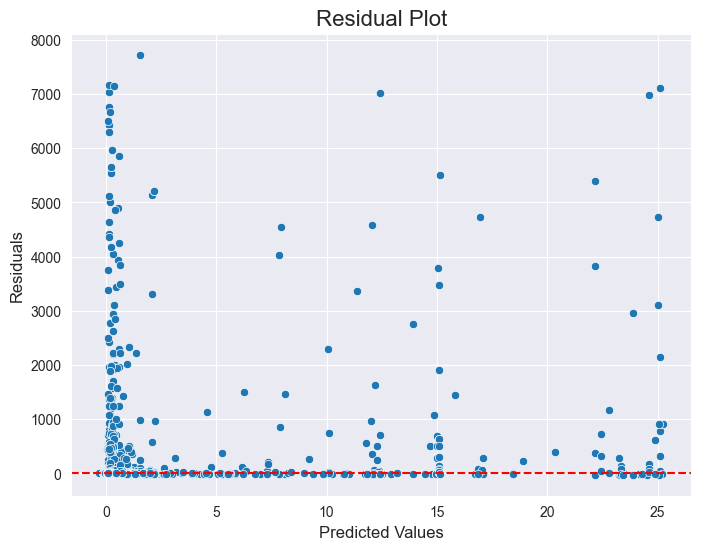

In [46]:
# Calculate residuals
residuals = y_test - y_pred_svr

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.show()

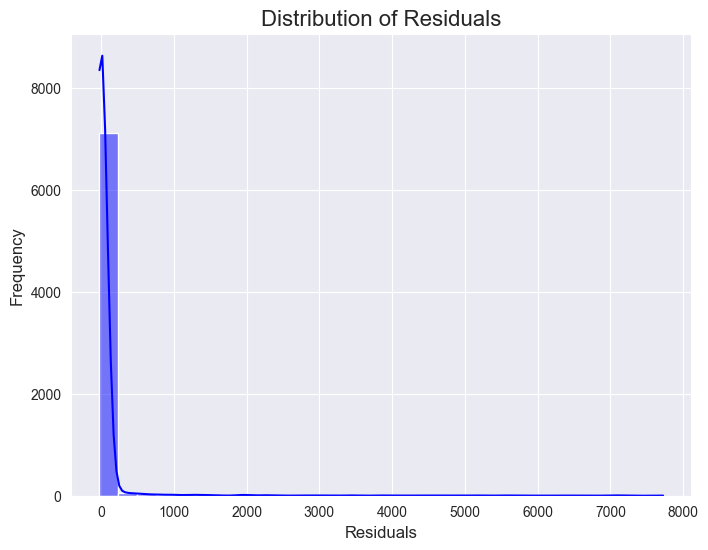

In [47]:
# Plot distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

> Overall prediction worked well at the lower end but suffers due to the extreme outliers in the target variable.

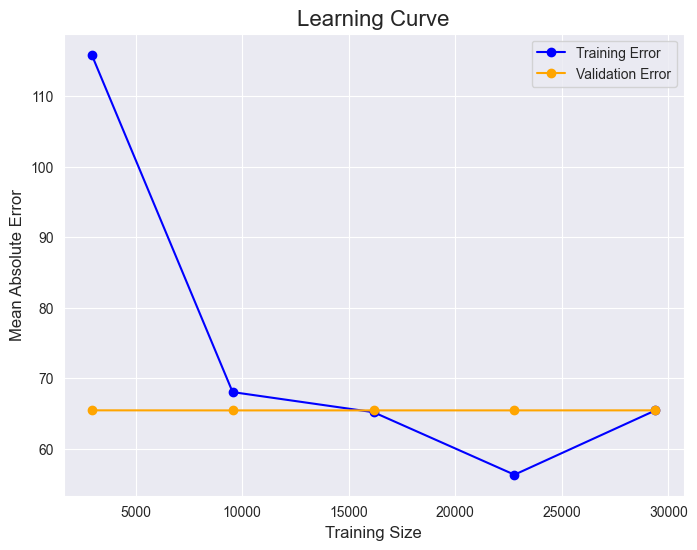

In [49]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(svr_best, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate mean and standard deviation of scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Error', color='blue')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Error', color='orange')
plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Section 7: Conclusion and Limitations

> Overall I found that I was able to improve on the baseline regression model of predicting means, with Support Vector Regression showing the best performance overall. With a mean absolute error in the base model of 567 compared to the benchmark  of 1168, the Support Vector Regression showed good capacity to deal with my prediction task.
> 
> Support vector machines performed better for several reasons. The first is its ability to penalize noise and ignore the small variations in my data. Support Vector Regression is also adept at dealing with skewness, which is present in my target variable to a large degree. It also has built in capacity to regularize my data ensuring that I don't overfit. 
> 
> In terms of limitations, the data creation and transformation could have been refined to deal with polygons rather than squares, ensuring I have more accuracy in how I assign regions to latitude and longitude. I could also incorporate more appropriate outlier detection methods like utilizing Gaussian Mixtures. It is clear now that the major error driver in my model was the fact that I didn't handle outliers in the beginning and considered them valid data points. More research into how to include these into my model and how to properly utilize them would've been helpful. In addition to this a better clustering mechanism designed to deal with large datasets but more suited for non linear problems would've been beneficial. Agglomerative clustering comes to mind in this regard. Better hyperparameter tuning for my support vector machine also would've provided for increased value, however given how computationally intensive it was I was unable to run additional tests. 
>